# ZYu Data Helper 1

## Load files to `./train/` and create `/train/labels.json`

STEPS

First unzip `lines.tgz` into folder "data/line_data", also put the file `lines.txt` there.



- Read `line.txt` into a data-frame, which will serve as `index` to data-files

- Choose some files from the `index` to serve as train data

- Copy those files to `data/train`

- Create `labels.json` and place it in `data/train`

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tnrange, tqdm_notebook


# Preliminary EDA

In [2]:
!head -23 line_data/lines.txt

#--- lines.txt ---------------------------------------------------------------#
#
# iam database line information
#
# format: a01-000u-00 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     a01-000u-00  -> line id for form a01-000u
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            err: segmentation of line has one or more errors
#
#                        notice: if the line could not be properly segmented
#                                the transcription and extraction of the whole
#                                line should not be affected negatively
#
#     154             -> graylevel to binarize line
#     19              -> number of components for this line
#     408 746 1663 91 -> bounding box around this line in x,y,w,h format
#
#     A|MOVE|to|stop|Mr.|Gaitskell|from
#                     -> transcription for this line. word tokens are separated
#                    

In [3]:
!head -25 line_data/lines_copy.txt

a01-000u-00 ok 154 19 408 746 1661 89 A|MOVE|to|stop|Mr.|Gaitskell|from
a01-000u-01 ok 156 19 395 932 1850 105 nominating|any|more|Labour|life|Peers
a01-000u-02 ok 157 16 408 1106 1986 105 is|to|be|made|at|a|meeting|of|Labour
a01-000u-03 err 156 23 430 1290 1883 70 M Ps|tomorrow|.|Mr.|Michael|Foot|has
a01-000u-04 ok 157 20 395 1474 1830 94 put|down|a|resolution|on|the|subject
a01-000u-05 err 156 21 379 1643 1854 88 and|he|is|to|be|backed|by|Mr.|Will
a01-000u-06 ok 159 20 363 1825 2051 87 Griffiths|,|M P|for|Manchester|Exchange|.
a01-000x-00 ok 182 30 375 748 1561 148 A|MOVE|to|stop|Mr.|Gaitskell|from|nominating
a01-000x-01 ok 181 23 382 924 1595 148 any|more|Labour|life|Peers|is|to|be|made|at|a
a01-000x-02 ok 181 30 386 1110 1637 140 meeting|of|Labour|0M Ps|tomorrow|.|Mr.|Michael
a01-000x-03 ok 179 22 375 1276 1584 154 Foot|has|put|down|a|resolution|on|the|subject
a01-000x-04 ok 173 25 397 1458 1647 148 and|he|is|to|be|backed|by|Mr.|Will|Griffiths|,
a01-000x-05 ok 173 16 393 1635 1082 

### NOTE

There are lines (4, 13 ...) with label containing spaces that can cause trouble when spliting by " ":

`a01-000x-05 ok 173 16 393 1635 1082 155 0M P|for|Manchester|Exchange|.`

EDA shows 13317 rows have 9 fields, but there are 23 rows with 10 fields, and 13 rows with 11 fields, these will cause trouble if reading the 'lines_copy.txt' file into CSV.

In [ ]:
# SHOW LINES WITH > 9 FIELDS
# count the number of fields if delimited by " "
from collections import defaultdict

file_in = 'line_data/lines_copy.txt'

fhand = open(file_in)

num_count = defaultdict(int)

for line in fhand:
    num = len(line.split(" "))
    num_count[num] +=1
    if num > 9:
        print(line)

fhand.close()

num_count

# 1. Read meta-data into a dataframe

In [4]:
file_in = 'line_data/lines_copy.txt'

fhand = open(file_in)
data_list = [] 

for line in fhand:
    item = line.split(" ")   # split the line
    num = len(item)          # number of fields if line delimited by " "
    
    if num == 9:             # good lines
        label = item[8]      # last field is label if only 9 field
    else:                    # bad lines with spaces in "label"
        label = " ".join(item[8:])    # join the remaining fields - this is label

    new_data  ={'id': item[0], 
                'wseg_status': item[1], 
                'graylevel': int(item[2]), 
                'num_components': int(item[3]), 
                'x': int(item[4]), 
                'y': int(item[5]), 
                'w': int(item[6]), 
                'h': int(item[7]), 
                'label': label.rstrip().replace("|", " ")}   # remove "\n", replace "|" with " "
    
    data_list.append(new_data)
    
fhand.close()

df = pd.DataFrame(data_list, 
                  columns=['id', 'wseg_status', 'graylevel', 'num_components', 'x', 'y', 'w', 'h', 'label'])

df.head()

,id,wseg_status,graylevel,num_components,x,y,w,h,label
0,a01-000u-00,ok,154,19,408,746,1661,89,A MOVE to stop Mr. Gaitskell from
1,a01-000u-01,ok,156,19,395,932,1850,105,nominating any more Labour life Peers
2,a01-000u-02,ok,157,16,408,1106,1986,105,is to be made at a meeting of Labour
3,a01-000u-03,err,156,23,430,1290,1883,70,M Ps tomorrow . Mr. Michael Foot has
4,a01-000u-04,ok,157,20,395,1474,1830,94,put down a resolution on the subject


In [5]:
df.dtypes

id                object
wseg_status       object
graylevel          int64
num_components     int64
x                  int64
y                  int64
w                  int64
h                  int64
label             object
dtype: object

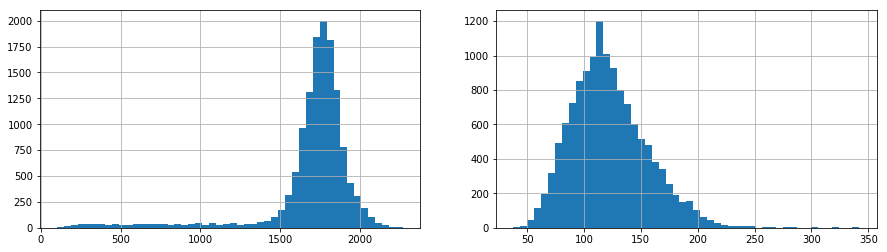

In [6]:
plt.figure(1, figsize=(15,4))
plt.subplot(121)
df['w'].hist(bins=50)
plt.subplot(122)
df['h'].hist(bins=50)
plt.show()

# 2. Choose files from the dataframe

- `wseg_status` has 11344 `ok`, 2009 `err`

- df has 11 files with `w==1600` and 161 files with `h==128`

- for initial test, choose those files with `w==1600` or `h==128`

In [7]:
df_train= df[df['h']==128]

df_test = df[df['w']==1600]

print(df_train.shape)
print(df_test.shape)

df_test.head()

(161, 9)
(11, 9)


,id,wseg_status,graylevel,num_components,x,y,w,h,label
1075,a03-066-01,ok,203,19,345,908,1600,120,"remove these doubts , and to persuade the"
1377,a05-013-00,err,176,19,363,757,1600,73,The scheme will be subject to Cabinet
1830,a06-147-02,ok,179,28,352,1283,1600,62,WEST GERMANY - Russia would like to see a clear #
3057,c03-003b-03,ok,151,10,324,1311,1600,111,the marriage of the central characters to their
3281,c03-081b-00,ok,154,9,326,749,1600,128,"Arguably , the dramatist has committed a"


# 3. Copy the chosen files to the destination and create json

For example, the first line:

- source: `./line_data/a03/a03-066/a03-066-01.png`

- destination: `./train/a03-066-01.png`

- label: `remove|these|doubts|,|and|to|persuade|the`

Work flow:

- initialize `file_list={}`

- loop through each line in the data frame

- use `id` field to create `source` and `destination`, `file_name`

- use `label` to create `label`

- copy `source` to `destination`

- add `{file_name: label}` to `file_list`

- create `labels.json` and put it in `./train`



### Define helper functions

In [8]:
def clean_folder(destination_dir):
    """
    only delete files and to used the os.path.join() method  
    If you also want to remove subdirectories, uncomment the elif statement.
    """
    
    import os, shutil
    folder = destination_dir
    
    count = 0
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
                count += 1
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
    print("Successfully removed", count, "files")        
    

def copy_files(df, source_dir, destination_dir):
    """
    copying files from source to destionation
    INPUT: df is a dataframe containing file information
    OUTPUT: json_list of {file_name:file_label} pairs    
    """

    from shutil import copy2
    json_dict = dict()

    for i in tnrange(df.shape[0], desc='copying files'):    

        # read data from each row
        file_data = df.iloc[i]            # each line in dataframe
        file_id = file_data['id']         # data for file
        file_name = file_id + '.png'      # file_name
        file_label = file_data['label']   # label
        
        # create source and destination 
        id_pc = file_id.split("-")
        source = source_dir + id_pc[0] + "/" + id_pc[0] + "-" + id_pc[1] + "/" + file_name
        destination = destination_dir  + file_name

        # copy source to destination
        copy2(source, destination)

        # append the {file_name: file_label} to json_list
        json_dict[file_name]= file_label

    return json_dict

def write_json_file(destination_dir, json_dict):
    """
    write json to the 'labels.json file in the destination directory
    """
    import json

    with open(destination_dir + 'labels.json', 'w') as fout:
        json.dump(json_dict, fout)
        
    print(destination_dir+'labels.json has been created.')

### Copy files listed in the input dataframe to destination

In [9]:
source_dir = './line_data/'
destination_dir = './train/'

In [10]:
# OPTIONAL: clean the destination folder if needed
clean_folder(destination_dir)

Successfully removed 162 files


In [11]:
# copying files from source to destination
json_dict = copy_files(df_train, source_dir, destination_dir)

print("Copied", len(json_dict), "files.")

A Jupyter Widget


Copied 161 files.


In [12]:
# take a look
!ls train | wc 

    161     161    2456


### Write json to `labels.json` and put it in destination directory

In [13]:
write_json_file(destination_dir, json_dict)

./train/labels.json has been created.


In [14]:
!cat ./train/labels.json

{"a01-003-02.png": "turn down the Foot-Griffiths resolution . Mr.", "a01-003x-03.png": "will be that as Labour 0M Ps opposed the Govern-", "a01-020-03.png": "to the Africans and Liberals attending . These", "a01-020-06.png": "are studying them today . The conference", "a01-107-00.png": "We believe that a comprehensive medical service , free to the patient", "a02-067-01.png": "should not be bound over for disturbing", "a02-067-06.png": "putting his affairs in order , and", "a02-098-03.png": "suggestion that there may be fresh concessions to the", "a02-120-05.png": "It was last used a year ago , to deal", "a03-023-03.png": "of the pro-communists . Most of the", "a03-066-07.png": "to contemplate in an election year .", "a04-039-00.png": "In VIENNA , before flying off to Moscow ,", "a04-089-06.png": "British territory . \" He pointed out that", "a04-092-06.png": "circles , but in public opinion . \" Earl Russell", "a05-004-07.png": "organisation . Mr. Watkinson , Minister of Defence ,", "a

### copy some files to `./test` as well

In [15]:
source_dir = './line_data/'
destination_dir = './test/'

# OPTIONAL: clean the destination folder if needed
clean_folder(destination_dir)

Successfully removed 12 files


In [16]:
# copying files from source to destination
json_dict = copy_files(df_test, source_dir, destination_dir)

print("Copied", len(json_dict), "files.")

A Jupyter Widget


Copied 11 files.


In [17]:
write_json_file(destination_dir, json_dict)

./test/labels.json has been created.


In [18]:
!cat ./test/labels.json

{"a03-066-01.png": "remove these doubts , and to persuade the", "a05-013-00.png": "The scheme will be subject to Cabinet", "a06-147-02.png": "WEST GERMANY - Russia would like to see a clear #", "c03-003b-03.png": "the marriage of the central characters to their", "c03-081b-00.png": "Arguably , the dramatist has committed a", "e01-119-06.png": "( Fig. 3 ) . Loop thread round little finger ,", "e02-086-04.png": "any case may be regarded as a good beginning to", "f03-182-02.png": "sympathy . And you want to get it from the word", "h04-000-00.png": "Nevertheless , average net family income", "h06-092-04.png": "carried by a short length of belt", "k07-067a-00.png": "He was having a ball ! He twiddled the TV set with"}